In [1]:
def draw_mol_with_SVG(mol, molSize=(450,150)):
    from IPython.display import SVG 
    from rdkit import Chem
    from rdkit.Chem import rdDepictor  
    from rdkit.Chem.Draw import rdMolDraw2D
    from rdkit.Chem.MolStandardize import rdMolStandardize
    """Use SVG to draw an RDKit molecule, mol."""
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():        
        rdDepictor.Compute2DCoords(mc) # Compute 2D coordinates
    # Initialize the drawer with the size
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc) # Draw the molcule
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText() # Get the SVG string
    display(SVG(svg.replace('svg:',''))) # Fix the SVG string and display

# Similarity Search

**Similarity search** is used to find compounds that have similar structural and/or chemical properties to a known drug or lead compound. The goal is to identify new compounds that are likely to have similar biological activity as the known compound, but with improved properties such as increased potency, reduced side effects, or improved pharmacokinetics.

There are different methods for performing similarity search in drug design. One of the most common methods is to use **molecular fingerprints**, which are numerical representations of the chemical structure of a compound. Fingerprints are calculated using various algorithms that encode information about the compound's atoms, bonds, and chemical groups. Another common method is to use **molecular descriptors**, which are numerical values calculated from the molecular structure of a compound that describe various chemical and physical properties of the compound.

Once the fingerprints or descriptors are calculated, a **similarity measure** such as Tanimoto coefficient or Euclidean distance is used to compare the similarity between the query compound and the compounds in the database. The compounds with the highest similarity scores are considered as potential drug candidates.

Similarity search can be used as an initial screening step in drug design, to quickly identify a large number of potential drug candidates, which can then be further evaluated using more computationally expensive methods such as molecular dynamics simulations or docking studies.

## Fingerprints

In [2]:
import time
import numpy as np
import pandas as pd
from sklearn import metrics
from functools import partial
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem.Scaffolds import MurckoScaffold

from rdkit.Chem import AllChem 
from rdkit.Chem import ChemicalFeatures 
from rdkit.Chem.Pharm2D import Generate
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from pmapper.customize import load_factory # fdef with SMARTS

In [3]:
# Topological Fingerprints
def gen_fp_rdkit(s):
    return Chem.RDKFingerprint(Chem.MolFromSmiles(s))

In [4]:
# Morgan Fingerprints (Circular Fingerprints)
def gen_fp_morgan(r, nbits, s):
    return AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), r, nBits=nbits)

In [5]:
# Pharmacophore Fingerprints
def gen_fp_pharm(s):
    featFactory = load_factory()
    sigFactory = SigFactory(featFactory, minPointCount=2, maxPointCount=3, trianglePruneBins=False)
    sigFactory.SetBins([(0, 2), (2, 5), (5, 8)])
    sigFactory.Init()
    
    return Generate.Gen2DFingerprint(Chem.MolFromSmiles(s), sigFactory)

## Similarity search algorithms and similarity measures

Euclidean Distance: a measure of the straight-line distance between two points in a Euclidean space. Euclidean distance is simple to calculate and is widely used in machine learning, but may not be the best choice in situations where the data is not uniformly distributed.

Cosine Similarity: a measure of similarity between two vectors based on the angle between them

In [6]:
similarity_scores = pd.DataFrame(data={
    'metric': ['Tanimoto', 'Dice', 'Cosine', 'Sokal', 'McConnaughey'],
    'min': [0, 0, 0, 0, 0],
    'max': [1, 1, 1, 1, 1],
    'formula': ['𝑐/(𝑎+𝑏+𝑐)', '(2∗𝑐)/((𝑎+𝑐)+(𝑏+𝑐))', '𝑐/√((𝑎+𝑐)∗(𝑏+𝑐))', '𝑎/(𝑎+2𝑏+2𝑐)', '(𝑎^2−𝑏𝑐)/((𝑎+𝑏)(𝑎+𝑐))']
                                      })
similarity_scores

,metric,min,max,formula
0,Tanimoto,0,1,𝑐/(𝑎+𝑏+𝑐)
1,Dice,0,1,(2∗𝑐)/((𝑎+𝑐)+(𝑏+𝑐))
2,Cosine,0,1,𝑐/√((𝑎+𝑐)∗(𝑏+𝑐))
3,Sokal,0,1,𝑎/(𝑎+2𝑏+2𝑐)
4,McConnaughey,0,1,(𝑎^2−𝑏𝑐)/((𝑎+𝑏)(𝑎+𝑐))


In [7]:
def calc_similarity_score(metric, qfp, fp):
    if metric == 'Tanimoto':
        return round(DataStructs.TanimotoSimilarity(qfp, fp), 4)
    elif metric == 'Dice':
        return round(DataStructs.DiceSimilarity(qfp, fp), 4)
    elif metric == 'Cosine':
        return round(DataStructs.CosineSimilarity(qfp, fp), 4)
    elif metric == 'Sokal':
        return round(DataStructs.SokalSimilarity(qfp, fp), 4)
    elif metric == 'McConnaughey':
        return round(DataStructs.McConnaugheySimilarity(qfp, fp), 4)
    else:
        return

## Interpretation of similarity scores

In [8]:
def draw_roc(y_true, **scores):
    plt.title('Receiver Operating Characteristic')
    
    y_true = np.array(y_true)
    
    for t, s in scores.items():
        s = np.array(s)
        fpr, tpr, thresholds = metrics.roc_curve(y_true, s, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label = f'{t} (AUC = %0.2f)' % roc_auc)
        
    plt.legend(loc = 'best')
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## TEST

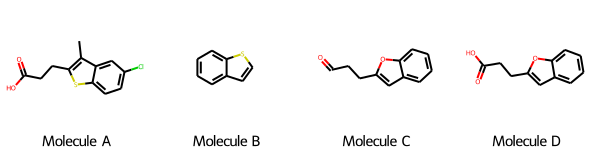

In [9]:
smiles = ['Cc1c(CCC(O)=O)sc2ccc(Cl)cc12',
          'c1ccc2sccc2c1',
          'O=CCCc1cc2ccccc2o1',
          'OC(=O)CCc1cc2ccccc2o1'
          ]

names  = ['Molecule A',
          'Molecule B',
          'Molecule C',
          'Molecule D']

mols   = [Chem.MolFromSmiles(s) for s in smiles]

Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(150,150), legends=['  '+n+'  ' for n in names], useSVG=True)

In [10]:
fps = [gen_fp_morgan(2, 1028, s) for s in smiles]

scores = pd.DataFrame(columns=['FP', 'Query_id', 'Mol_id', 'Metric', 'Score'])
i = 0
for indx in ['Tanimoto', 'Dice', 'Cosine', 'Sokal', 'McConnaughey']:
    for n, fp in zip(names[1:], fps[1:]):
        ss = calc_similarity_score('Tanimoto', fps[0], fp)
        scores.loc[i] = [names[0], n, indx, ss, 'Morgan']
        i += 1
scores

,FP,Query_id,Mol_id,Metric,Score
0,Molecule A,Molecule B,Tanimoto,0.1556,Morgan
1,Molecule A,Molecule C,Tanimoto,0.1273,Morgan
2,Molecule A,Molecule D,Tanimoto,0.3000,Morgan
3,Molecule A,Molecule B,Dice,0.1556,Morgan
4,Molecule A,Molecule C,Dice,0.1273,Morgan
5,Molecule A,Molecule D,Dice,0.3000,Morgan
6,Molecule A,Molecule B,Cosine,0.1556,Morgan
7,Molecule A,Molecule C,Cosine,0.1273,Morgan
8,Molecule A,Molecule D,Cosine,0.3000,Morgan
9,Molecule A,Molecule B,Sokal,0.1556,Morgan


In [11]:
fps = [gen_fp_pharm(s) for s in smiles]

scores = pd.DataFrame(columns=['Query_id', 'Mol_id', 'Metric', 'Score', 'FP'])
i = 0
for indx in ['Tanimoto', 'Dice', 'Cosine', 'Sokal', 'McConnaughey']:
    for n, fp in zip(names[1:], fps[1:]):
        ss = calc_similarity_score('Tanimoto', fps[0], fp)
        scores.loc[i] = [names[0], n, indx, ss, '2D Pharmacophore']
        i += 1
scores

,Query_id,Mol_id,Metric,Score,FP
0,Molecule A,Molecule B,Tanimoto,0.0000,2D Pharmacophore
1,Molecule A,Molecule C,Tanimoto,0.2424,2D Pharmacophore
2,Molecule A,Molecule D,Tanimoto,0.4643,2D Pharmacophore
3,Molecule A,Molecule B,Dice,0.0000,2D Pharmacophore
4,Molecule A,Molecule C,Dice,0.2424,2D Pharmacophore
5,Molecule A,Molecule D,Dice,0.4643,2D Pharmacophore
6,Molecule A,Molecule B,Cosine,0.0000,2D Pharmacophore
7,Molecule A,Molecule C,Cosine,0.2424,2D Pharmacophore
8,Molecule A,Molecule D,Cosine,0.4643,2D Pharmacophore
9,Molecule A,Molecule B,Sokal,0.0000,2D Pharmacophore


## RUN

In [12]:
df = pd.read_csv('cyp3a4-clean.smi', sep='\t')

In [13]:
smls = df[df['pval'] == df['pval'].max()]['smiles'].tolist()[0]
df[df.smiles == smls]

,smiles,molecule_chembl_id,pval,status
1655,CC[C@@]1(N)CCCN(c2cc3c(c(=O)n(C)c(=O)n3C)n2Cc2...,CHEMBL1819091,10.658,1.0


In [14]:
y_true = df.status.tolist()

In [15]:
# Topological Fingerprints
start = time.time()

topol_fpq = gen_fp_rdkit(smls)
topol_fps = [gen_fp_rdkit(s) for s in df.smiles.tolist()]

print('Time of', df.shape[0], 'Tological Fingerprints generation:', round(time.time() - start, 3), 's')
print('Length of the Topological bit string:', len(topol_fpq.ToBitString()))

Time of 4653 Tological Fingerprints generation: 5.361 s
Length of the Topological bit string: 2048


In [16]:
# Morgan Fingerprints
start = time.time()

gen_fp_morgan_bit = partial(gen_fp_morgan, 2, 2048)

morgan_fpq = gen_fp_morgan_bit(smls)
morgan_fps = [gen_fp_morgan_bit(s) for s in df.smiles.tolist()]

print('Time of', df.shape[0], 'Morgan Fingerprints generation:', round(time.time() - start, 3), 's')
print('Length of the Morgan bit string:', len(topol_fpq.ToBitString()))

Time of 4653 Morgan Fingerprints generation: 0.8 s
Length of the Morgan bit string: 2048


In [17]:
# Pharmacophore Fingerprints
start = time.time()

pharm_fpq = gen_fp_pharm(smls)
pharm_fps = [gen_fp_pharm(s) for s in df.smiles.tolist()]

print('Time of', df.shape[0], 'Pharmacophore Fingerprints generation:', round(time.time() - start, 3), 's')
print('Length of the 2D Pharmacophore bit string:', len(pharm_fpq.ToBitString()))

Time of 4653 Pharmacophore Fingerprints generation: 52.355 s
Length of the 2D Pharmacophore bit string: 1575


In [18]:
# Calculate Tanimoto score
start = time.time()

calc_tanimoto = partial(calc_similarity_score, 'Tanimoto')

topol_tanimoto = [calc_tanimoto(topol_fpq, x) for x in topol_fps]
morgan_tanimoto = [calc_tanimoto(morgan_fpq, x) for x in morgan_fps]
pharm_tanimoto = [calc_tanimoto(pharm_fpq, x) for x in pharm_fps]

print('Time of tanimoto coefficient calculation:', round(time.time() - start, 3), 'c')

Time of tanimoto coefficient calculation: 0.059 c


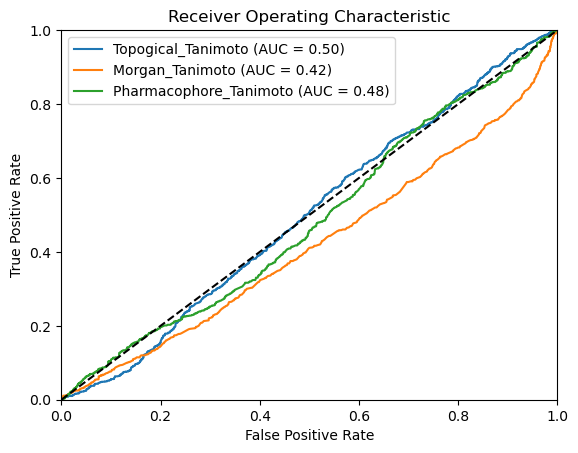

In [19]:
# Interpretation of similarity scores

df_scores = pd.DataFrame(data={
            'y_true': y_true, 'topol_tanimoto': topol_tanimoto,
            'morgan_tanimoto': morgan_tanimoto, 'pharm_tanimoto': pharm_tanimoto
                               })

draw_roc(df_scores['y_true'].tolist(), 
         Topogical_Tanimoto=df_scores['topol_tanimoto'].tolist(), 
         Morgan_Tanimoto=df_scores['morgan_tanimoto'].tolist(),
         Pharmacophore_Tanimoto=df_scores['pharm_tanimoto'].tolist()
        )

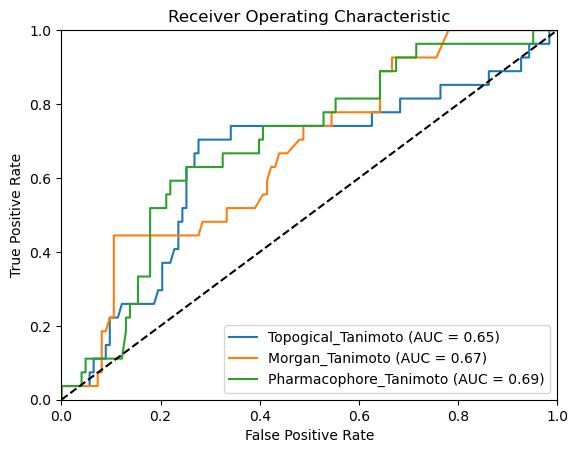

In [20]:
df_scores = df_scores.sort_values(by=['morgan_tanimoto'], ascending=False)

draw_roc(df_scores['y_true'].tolist()[:150], 
         Topogical_Tanimoto=df_scores['topol_tanimoto'].tolist()[:150], 
         Morgan_Tanimoto=df_scores['morgan_tanimoto'].tolist()[:150],
         Pharmacophore_Tanimoto=df_scores['pharm_tanimoto'].tolist()[:150]
        )

In [21]:
df_scores = df_scores.sort_values(by=['morgan_tanimoto'], ascending=False)

df_stat = pd.DataFrame(columns=['Percentage', 'MinScore', 'NumActives', 'NumMolecules', 'Precision'])

for i, p in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 1, 3, 5, 10, 15, 20, 30, 50, 100]):
    dft = df_scores[:int(p*(df_scores.shape[0] / 100))]
    
    df_stat.loc[i] = [p, dft.tail(1)['morgan_tanimoto'].tolist()[0],
                      dft[dft['y_true'] == 1].shape[0], dft.shape[0], 
                      round(dft[dft['y_true'] == 1].shape[0] / dft.shape[0], 3)]
df_stat

,Percentage,MinScore,NumActives,NumMolecules,Precision
0,0.1,0.6301,1.0,4.0,0.250
1,0.2,0.3827,1.0,9.0,0.111
2,0.3,0.2979,3.0,13.0,0.231
3,0.4,0.2812,6.0,18.0,0.333
4,0.5,0.2766,10.0,23.0,0.435
5,1.0,0.2151,12.0,46.0,0.261
6,3.0,0.1780,27.0,139.0,0.194
7,5.0,0.1651,42.0,232.0,0.181
8,10.0,0.1474,89.0,465.0,0.191
9,15.0,0.1379,129.0,697.0,0.185


/var/folders/58/6gqg3qf555lfcdvk2vbvf5_r0000gn/T/ipykernel_10247/1273680893.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(


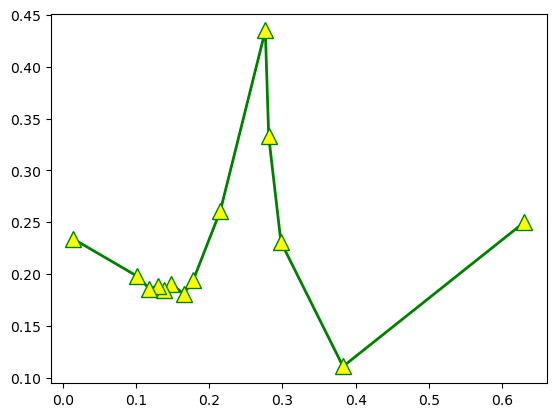

In [22]:
plt.plot(
    df_stat['MinScore'], df_stat['Precision'], 'o-', c ="green", 
    markerfacecolor='yellow', marker ="^", linewidth=2, markersize=12)
plt.show()

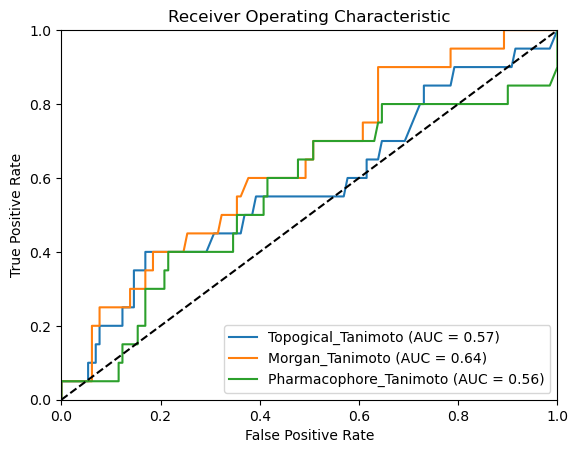

In [23]:
df_scores = df_scores.sort_values(by=['topol_tanimoto'], ascending=False)

draw_roc(df_scores['y_true'].tolist()[:150], 
         Topogical_Tanimoto=df_scores['topol_tanimoto'].tolist()[:150], 
         Morgan_Tanimoto=df_scores['morgan_tanimoto'].tolist()[:150],
         Pharmacophore_Tanimoto=df_scores['pharm_tanimoto'].tolist()[:150]
        )

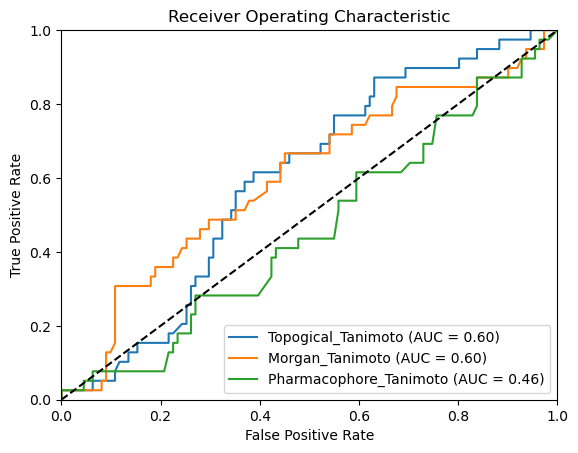

In [24]:
df_scores = df_scores.sort_values(by=['pharm_tanimoto'], ascending=False)

draw_roc(df_scores['y_true'].tolist()[:150], 
         Topogical_Tanimoto=df_scores['topol_tanimoto'].tolist()[:150], 
         Morgan_Tanimoto=df_scores['morgan_tanimoto'].tolist()[:150],
         Pharmacophore_Tanimoto=df_scores['pharm_tanimoto'].tolist()[:150]
        )

## Maximum Common Substructure

The Maximum Common Substructure (MCS) is a widely used concept in cheminformatics. It refers to the largest structural fragment that is present in two or more molecules and can be used to identify similar or related compounds.

In [25]:
def draw_mcs_mols(mols):
    res = rdFMCS.FindMCS(mols)
    smarts = res.smartsString
    mcs = Chem.MolFromSmarts(smarts)
    
    highlight_lists = [mol.GetSubstructMatch(mcs) for mol in mols]
    svg = Draw.MolsToGridImage(mols 
                               , highlightAtomLists = highlight_lists
                               , subImgSize=(300, 200)
                                    )
    return mcs, svg

In [26]:
df.sort_values('pval', ascending=False)[:3]

,smiles,molecule_chembl_id,pval,status
1655,CC[C@@]1(N)CCCN(c2cc3c(c(=O)n(C)c(=O)n3C)n2Cc2...,CHEMBL1819091,10.658,1.0
3515,COc1cc(NC(=O)C[C@@]2(C)C[C@H](c3cccc(Cl)c3)[C@...,CHEMBL3407558,10.298,1.0
3514,CC(C)(C)S(=O)(=O)C[C@H](C1CC1)N1C(=O)[C@@](C)(...,CHEMBL3407554,9.991,1.0


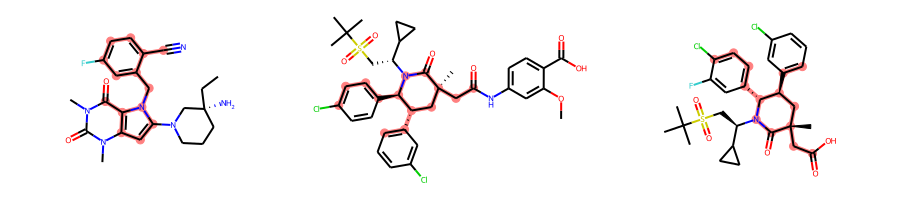

In [27]:
smls = df.sort_values('pval', ascending=False)['smiles'].tolist()[:3]
mols = [Chem.MolFromSmiles(x) for x in smls]
mcs, svg = draw_mcs_mols(mols)
svg

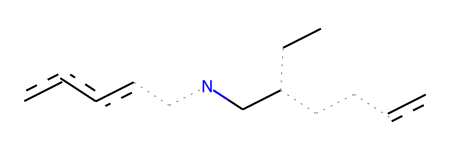

In [28]:
mcs

## Murcko Decomposition

Murcko Decomposition is a method of representing a chemical compound as a simplified, scaffold-like structure. 

The Murcko scaffold is calculated by removing the side chains and functional groups, such as amines, alcohols, acids, and esters, from a molecule. The remaining core structure is then identified and used as the Murcko scaffold.

The Murcko scaffold is often used in the field of cheminformatics as a way of reducing the complexity of a compound and making it easier to compare to other compounds. It can also be used for clustering similar compounds, virtual screening, and QSAR modeling.

In [29]:
def get_murcko_scaffold(s, verbose=False):
    core = MurckoScaffold.GetScaffoldForMol(Chem.MolFromSmiles(s))
    fw = MurckoScaffold.MakeScaffoldGeneric(core)
    
    if verbose:
        print('Molecule structure')
        draw_mol_with_SVG(Chem.MolFromSmiles(s))
        print('Core')
        draw_mol_with_SVG(core)
        print('Scaffold Generic')
        draw_mol_with_SVG(fw)
        
    return Chem.MolToSmiles(fw)

Molecule structure


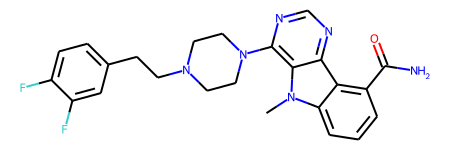

Core


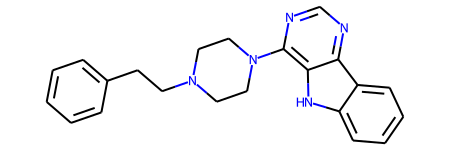

Scaffold Generic


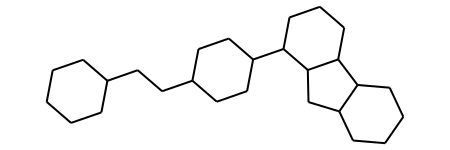

'C1CCC(CCC2CCC(C3CCCC4C5CCCCC5CC34)CC2)CC1'

In [30]:
get_murcko_scaffold(df['smiles'].tolist()[45], verbose=True)

In [31]:
start = time.time()

scaffolds = [get_murcko_scaffold(s) for s in df.smiles.tolist()]
dfs = pd.DataFrame(data={'mol_id': df.molecule_chembl_id.tolist(),
                         'status': df.status.tolist(),
                         'smiles': df.smiles.tolist(),
                         'murcko': scaffolds})
dfs = dfs.merge(dfs.groupby('murcko', as_index=False).size(), on='murcko')

print('Time of murcki scaffold generation:', time.time() - start)

Time of murcki scaffold generation: 15.366061687469482


In [32]:
dfs.sort_values(['status', 'size'], ascending=False)[:3]

,mol_id,status,smiles,murcko,size
3782,CHEMBL3907374,1.0,Cc1ccc(C[C@@H]2COCCN2C(=O)c2ccccc2-n2nccn2)cc1...,CC(C1CCCCC1CC1CCCC(C2CCCC2)C1)C1CCCCC1C1CCCC1,115
146,CHEMBL112532,1.0,CCCCOc1ccc(-n2ccnc2)cc1,C1CCC(C2CCCC2)CC1,68
154,CHEMBL358880,1.0,CCCCOc1ccc(-n2cncc2C)cc1,C1CCC(C2CCCC2)CC1,68


In [33]:
dfs[dfs['murcko'] == dfs.loc[3782, 'murcko']]['status'].sum()

1.0

In [34]:
dfs[dfs['murcko'] == dfs.loc[146, 'murcko']]['status'].sum()

4.0

In [35]:
print(dfs.drop_duplicates(subset=['murcko']).shape[0], 'molecules with unique scaffolds among', 
      dfs.shape[0], 'molecules')

print(dfs[dfs.status == 1].drop_duplicates(subset=['murcko']).shape[0], 'actives with unique scaffolds among',
      dfs[dfs.status == 1].shape[0], 'actives')

1762 molecules with unique scaffolds among 4653 molecules
540 actives with unique scaffolds among 1090 actives


## References:

- Holliday JD, Hu CY, Willett P., Grouping of Coefficients for the Calculation of Inter-Molecular Similarity and Dissimilarity using 2D Fragment Bit-Strings (2002), DOI: https://doi.org/10.2174/1386207024607338
- Visualizing Chemical Space by Pat Walters http://practicalcheminformatics.blogspot.com/2019/11/visualizing-chemical-space.html
- Metrics https://en.wikipedia.org/wiki/Precision_and_recall
- Daylight, Fingerprints - Screening and Similarity https://www.daylight.com/dayhtml/doc/theory/theory.finger.html

## Conclusion

1. We performed similarity searches using various types of fingerprints and evaluated the results using various similarity scores
2. We identified the Maximum Common Substructure of the active molecules
3. We examined the chemical diversity of the dataset using Murcko decomposition

To continue the tutorial on QSAR modeling, follow the link to the [main IPython Notebook](https://github.com/meddwl/skillbox/blob/main/QSAR/QSAR.ipynb)